# SNN-CLAPP

In [3]:
import matplotlib.pyplot as plt
from utils import load_NMNIST, load_PMNIST, train, test, load_half_MNIST
from model import CLAPP_SNN
import numpy as np
import torch
import seaborn as sns
color_list = sns.color_palette()
device = 'cpu'
epochs = 1
batch_size = 1
n_inputs = 14*14 #34 * 34 * 2
n_hidden = 2 * [512]
n_outputs = 10
folder = 'models/'
model_name = folder + 'SNN_CLAPP_1.pt'


## Dataset
N-MNIST 


torch.Size([1, 2, 1, 28, 14]) tensor([6])


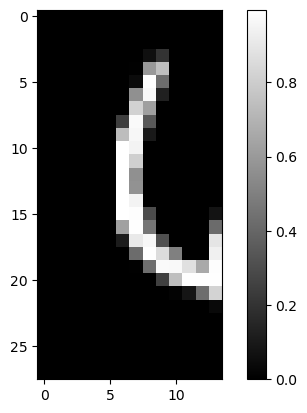

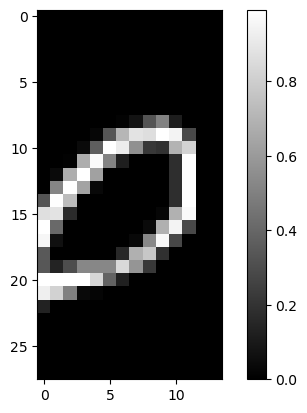

In [4]:
n_time_bins = 4
#train_loader, test_loader = load_PMNIST(n_time_bins, scale=0.9, patches=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
train_loader, test_loader = load_half_MNIST() #load_NMNIST(n_time_bins, batch_size=batch_size)

# Plot Example
frames, target = next(iter(train_loader))
print(frames.shape, target)
for i in range(2):
    plt.figure()
    plt.imshow(frames[0,i].view(28,14), cmap='gray')
    plt.colorbar()


## Load pretrained model

In [ ]:

SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load(model_name, map_location='cpu'))
#train(SNN, train_loader, 1, 'cpu')

<All keys matched successfully>

In [ ]:
losses, loss_per_digit, clapp_activation, target_list, clapp_losses = test(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)

# mean loss for const prediction: 2.3

10000it [01:33, 107.49it/s]


[tensor(1466.0863), tensor(1869.7328), tensor(1983.8931), tensor(3315.3425), tensor(2269.5317), tensor(4775.4888), tensor(1738.8403), tensor(1774.9706), tensor(2174.4829), tensor(1938.8379)]
Mean Loss: tensor(2.3307)


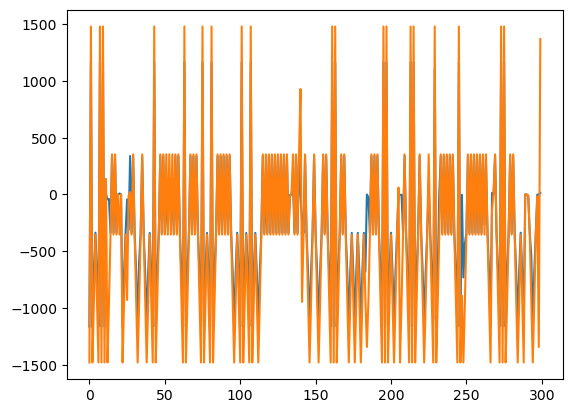

In [ ]:
plt.plot(torch.stack(clapp_losses).detach().cpu()[100:400,:])

# Analyze Weights Directly

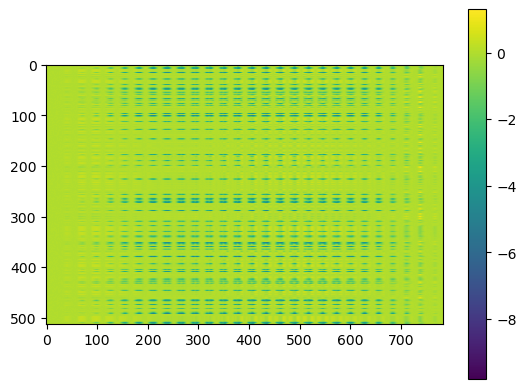

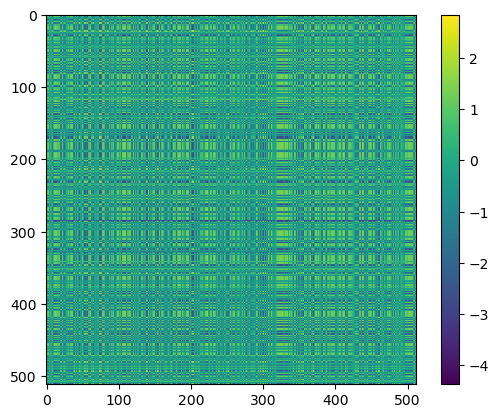

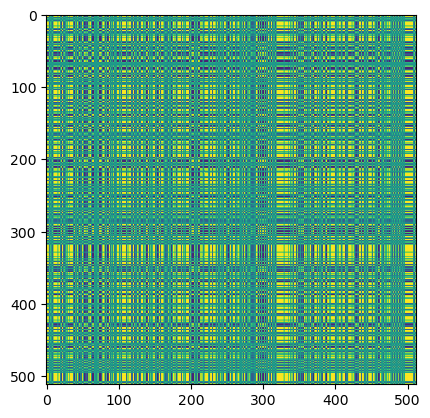

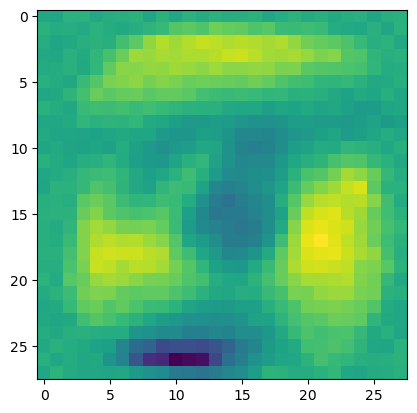

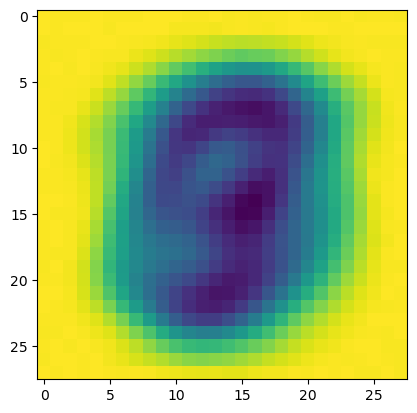

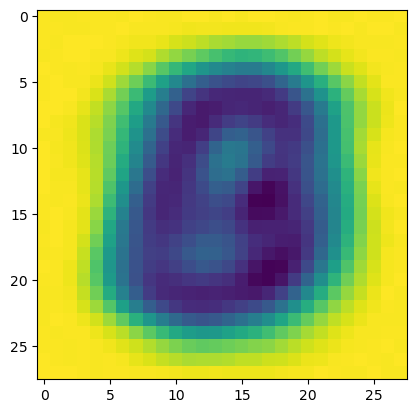

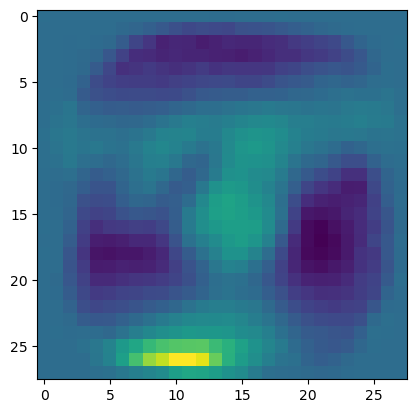

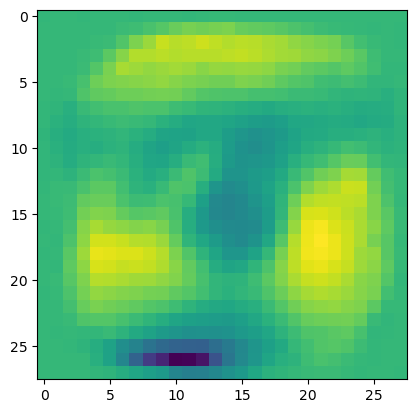

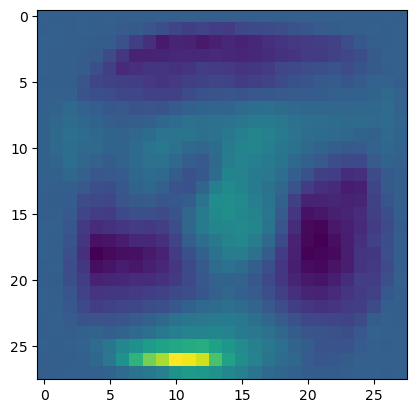

In [ ]:
layers = [SNN.clapp[0].fc.weight]
for i in range(1, len(SNN.clapp)):
    layers.append(SNN.clapp[i].fc.weight @ layers[-1])

for i in range(len(SNN.clapp)):
    plt.figure()
    plt.imshow(SNN.clapp[i].fc.weight.detach())
    plt.colorbar()
plt.figure()
plt.imshow(SNN.clapp[0].pred.weight.detach())
plt.show()
for lay in layers:
    for i in range(100, 103):
        plt.figure()
        plt.imshow(lay[i].view(28, 28).detach())

40000
tensor(2841)
torch.Size([40000, 512])
(10000, 2)
torch.Size([40000, 512])
(10000, 2)


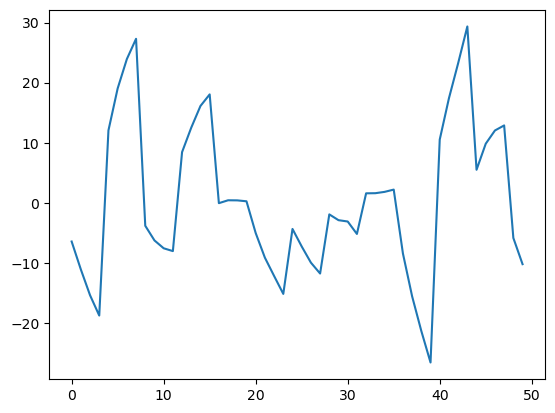

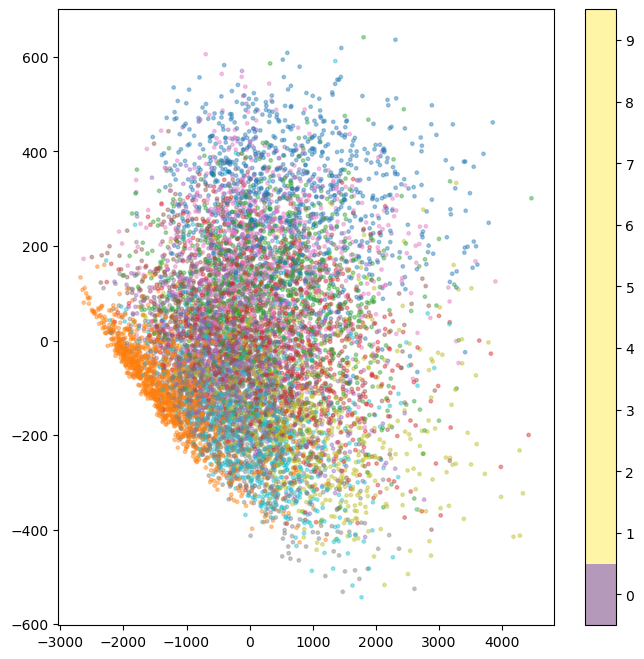

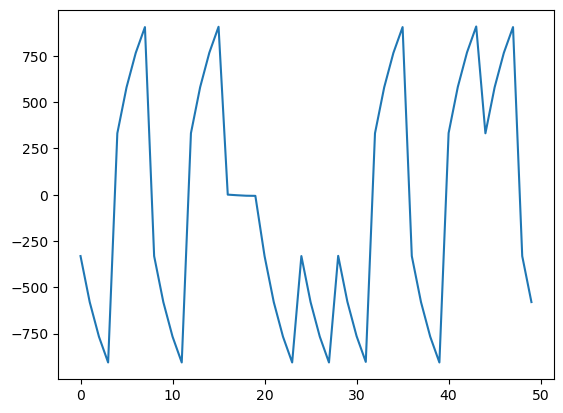

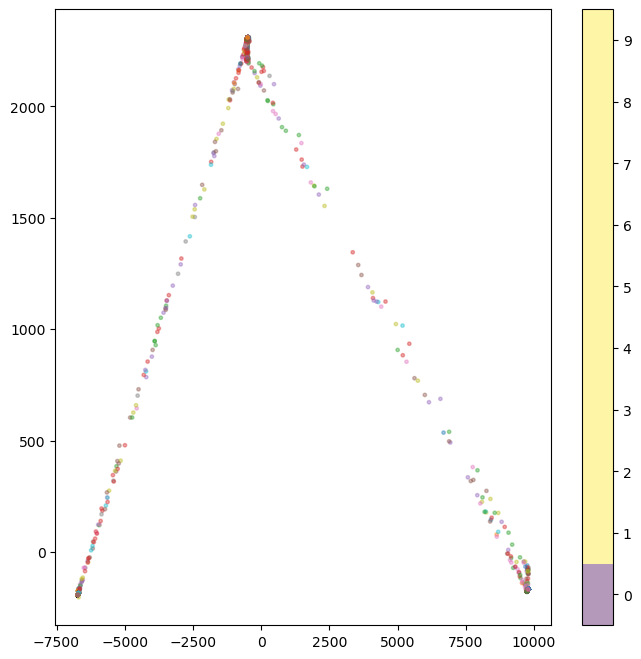

In [ ]:
%matplotlib inline
print(len(clapp_activation))
hidden_activities_transformed = torch.stack(clapp_activation).swapaxes(0,1)
print((SNN.out_proj.out_proj.weight < 0).sum())
#plt.plot(hidden_activities_transformed[1,:1000,:100])
from sklearn.decomposition import PCA
from umap import UMAP
umap = UMAP()
pca = PCA(n_components=2)

colors = [color_list[i] for i in torch.tensor(target_list)]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    # hat_diff = hat[1:] - hat[:-1]
    print(hat.shape)
    # hat_transform = umap.fit_transform(hat[::10].detach().cpu().numpy())
    hat_transform = pca.fit_transform(hat[::4].detach().cpu().numpy())
    print(hat_transform.shape)
    plt.figure()
    plt.plot(hat.cpu()[:50,3])
    plt.figure(figsize=(8,8))
    plt.scatter(hat_transform[:,0], hat_transform[:,1], s=6, c=colors[::4], alpha=0.4)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))


# Train output Projection

In [ ]:
# Gradient calculation + weight update
import snntorch.functional as SF
losses_out = []
SNN.out_proj.out_proj.reset_parameters()
optimizer = torch.optim.AdamW(SNN.out_proj.parameters(), lr=1e-3, weight_decay=1)
loss_fn = SF.ce_count_loss()
SNN.train()
mem_his_list = []
for i, (data, target) in enumerate(train_loader):
    logit_list = []
    data = data.squeeze()
    for step in range(data.shape[0]):
        optimizer.zero_grad()
        data_step = data[step].float().to(device)
        target = target.to(device)
        logits, mem_his, clapp_loss = SNN(data_step, target, 0)
        mem_his_list.append(mem_his)
        logit_list.append(logits)
        optimizer.step()
    
    losses_out.append(loss_fn(torch.stack(logit_list).unsqueeze(1), target))
    
    if i % 1000 == 999:
        print(i, sum(losses_out[-999:])/999)
plt.plot(losses_out)

999 tensor(3.2796)
1999 tensor(3.3735)
2999 tensor(3.3238)
3999 tensor(3.3107)
4999 tensor(3.3567)
5999 tensor(3.4031)
6999 tensor(3.3241)
7999 tensor(3.3302)
8999 tensor(3.2916)
9999 tensor(3.2842)
10999 tensor(3.2771)
11999 tensor(3.3325)


KeyboardInterrupt: 

Parameter containing:
tensor([[-8.3899, -8.4007, 12.2752,  ..., 12.2784, -8.4326, 12.2323],
        [12.8075, 12.8173, -4.0428,  ..., -4.0894, 12.8260, -4.0116],
        [-3.8435, -3.8557, -2.8363,  ..., -2.8679, -3.8923, -2.8254],
        ...,
        [-1.4319, -1.4137, -3.2997,  ..., -3.3184, -1.4190, -3.3040],
        [-2.2124, -2.1952, -3.6976,  ..., -3.6632, -2.2563, -3.6684],
        [-3.4056, -3.3446, -3.5249,  ..., -3.5530, -3.3838, -3.4776]],
       requires_grad=True)

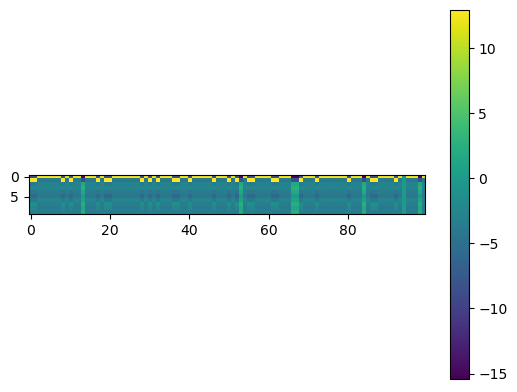

In [ ]:
plt.imshow(SNN.out_proj.out_proj.weight[:,:100].detach())
plt.colorbar()
SNN.out_proj.out_proj.weight

In [ ]:
SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load('models/SNN_CLAPP_0.pt'))
losses, loss_per_digit, clapp_activation, target_list = test(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)

10000it [01:56, 85.67it/s]


[tensor(4668.5688, device='cuda:0'), tensor(866.9744, device='cuda:0'), tensor(4916.2798, device='cuda:0'), tensor(4811.4790, device='cuda:0'), tensor(4678.0962, device='cuda:0'), tensor(4249.3657, device='cuda:0'), tensor(4563.7681, device='cuda:0'), tensor(785.2419, device='cuda:0'), tensor(4639.9868, device='cuda:0'), tensor(4806.7153, device='cuda:0')]
Mean Loss: tensor(3.8987, device='cuda:0')
